In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [9]:
target = "SalePrice"

In [ ]:
house_garage_yr_compare = pd.concat([train['YearBuilt'], train['GarageYrBlt']], axis=1)
house_garage_yr_compare.loc[house_garage_yr_compare['YearBuilt'] != house_garage_yr_compare['GarageYrBlt']]

In [3]:
train['YearBuilt'].corr(train['GarageYrBlt'])

0.825667484174342

In [7]:
train = train.drop(['Id'], axis='columns')
test = test.drop(['Id'], axis='columns')

In [16]:
corr = train.set_index(target).reset_index().corr().abs().sort_values(by=target, ascending=False)[target]
corr

C:\Users\D568\AppData\Local\Temp\ipykernel_17244\2655423338.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.set_index(target).reset_index().corr().abs().sort_values(by=target, ascending=False)[target]


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64

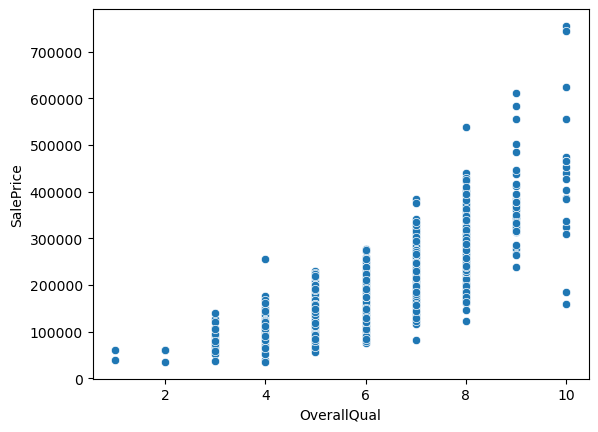

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [30]:
fig, ax = plt.subplots()
sns.scatterplot(x="OverallQual", y=target, data=train)
plt.show()
outlier = train[(train[target] < 200000) & (train['OverallQual'] == 10)]
train = train.drop(outlier.index)
outlier

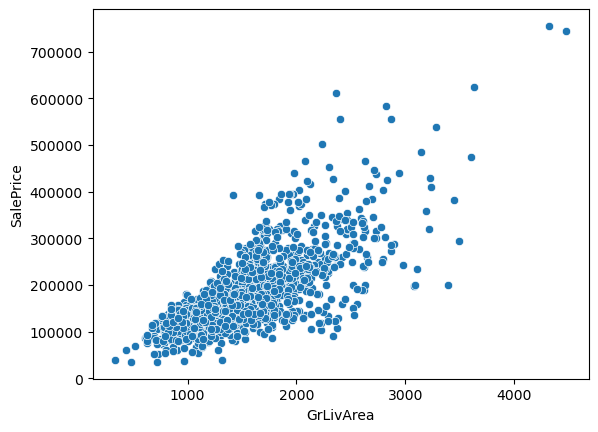

In [32]:
fig, ax = plt.subplots()
sns.scatterplot(x="GrLivArea", y=target, data=train)
plt.show()

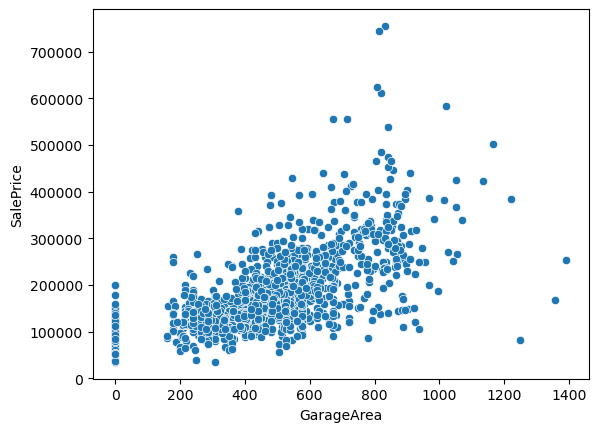

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
581,20,RL,98.0,12704,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2009,New,Partial,253293
1061,30,C (all),120.0,18000,Grvl,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,Shed,560,8,2008,ConLD,Normal,81000
1190,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000


In [43]:
fig, ax = plt.subplots()
sns.scatterplot(x="GarageArea", y=target, data=train)
plt.show()
outlier = train[(train[target] < 300000) & (train['GarageArea'] > 1200)]
train = train.drop(outlier.index)
outlier

수영장, 주차장, 지하실 등 시설의 유무로 NA 값들이 생김
GarageX, BsmtX, MasVnrX 값들이 동일한 값들이 동일한 NA값들을 가짐. 해당 변수들의 의존성을 분리할 필요가 있어 보임
매우 많은 NA값을 가지는 Pool, MiscFeature, Alley, Fence 값들과 관련 변수들을 삭제함

In [ ]:
train_na = train.isna().sum()
train_na = train_na[train_na > 0]
percent = train_na / len(train)
na_df = pd.concat([train_na, percent], axis=1, keys=['count', 'percent']).sort_values('count', ascending=False)

,count,percent
PoolQC,1449,0.995876
MiscFeature,1402,0.963574
Alley,1364,0.937457
Fence,1174,0.806873
FireplaceQu,689,0.473540
LotFrontage,258,0.177320
GarageType,81,0.055670
GarageYrBlt,81,0.055670
GarageFinish,81,0.055670
GarageQual,81,0.055670


In [45]:
train.set_index(target).reset_index().corr().abs().sort_values(by='GarageArea', ascending=False)['GarageArea']

C:\Users\D568\AppData\Local\Temp\ipykernel_17244\3587497372.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.set_index(target).reset_index().corr().abs().sort_values(by='GarageArea', ascending=False)['GarageArea']


GarageArea       1.000000
GarageCars       0.889254
SalePrice        0.641664
OverallQual      0.574778
GarageYrBlt      0.572678
YearBuilt        0.487211
1stFlrSF         0.477898
TotalBsmtSF      0.476729
GrLivArea        0.464032
FullBath         0.414723
YearRemodAdd     0.379195
MasVnrArea       0.366825
TotRmsAbvGrd     0.331704
LotFrontage      0.317076
BsmtFinSF1       0.279285
Fireplaces       0.263983
OpenPorchSF      0.233380
WoodDeckSF       0.223203
BsmtUnfSF        0.179751
BsmtFullBath     0.174955
HalfBath         0.163022
LotArea          0.157690
OverallCond      0.144025
2ndFlrSF         0.141176
EnclosedPorch    0.120268
MSSubClass       0.106837
BedroomAbvGr     0.067966
LowQualFinSF     0.067778
KitchenAbvGr     0.063349
ScreenPorch      0.056241
3SsnPorch        0.037496
MoSold           0.033180
MiscVal          0.029864
YrSold           0.028955
PoolArea         0.027648
BsmtHalfBath     0.022042
BsmtFinSF2       0.014954
Name: GarageArea, dtype: float64

C:\Users\D568\AppData\Local\Temp\ipykernel_17244\870845909.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


<AxesSubplot: >

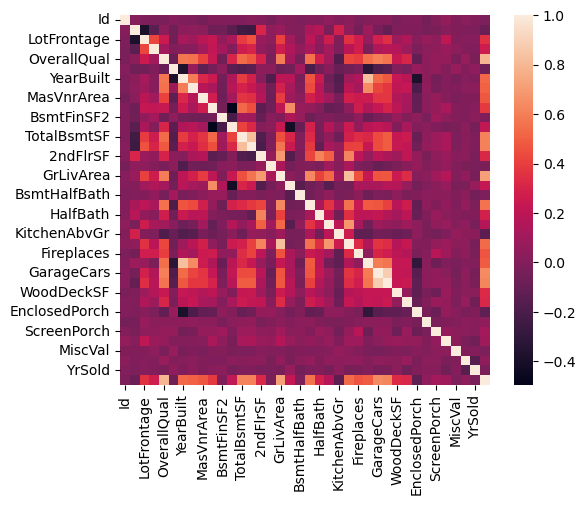

In [4]:
corr_matrix = train.corr()
f, ax = plt.subplots()
sns.heatmap(corr_matrix, vmax=1, square=True)

In [ ]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending=False)
null_table = pd.concat([total, percent], axis=1, keys=["total", "percent"])
null_table.loc[null_table["total"] > 0]

PoolQC는 수영장의 품질을 나타내는 특성이지만 대부분의 집은 수영장이 없어서 선택되었다. PoolArea는 수영장이 없는 집은 0으로 표시되어 선택되지 않았고 수영장을 가진 집도 7건 밖에 되지 않아 삭제하기로 결정하였다.

In [ ]:
hasPool = train['PoolArea']
hasPool.loc[hasPool > 0] = 1
hasPool.value_counts()
train = train.drop('PoolArea', axis='columns')

In [ ]:
train = train.drop("Id", axis="columns")

z_score = (train["SalePrice"] - train["SalePrice"].mean()) / train["SalePrice"].std()
print(len(train))
train = train[z_score.abs().sort_values() < 3]
print(len(train))

In [ ]:
from scipy.stats import norm, probplot


sns.histplot(train['SalePrice'])
fig = plt.figure()
res = probplot(train['SalePrice'], plot=plt)

In [ ]:
test = np.log(train['SalePrice'])
sns.distplot(test)
fig = plt.figure()
res = probplot(test, plot=plt)

In [ ]:
object_columns = []
numeric_columns = []
for col in train.columns:
    if (train[col].dtype == 'object'):
        object_columns.append(col)
    else:
        numeric_columns.append(col)
print(object_columns)

In [ ]:
dummy_train = pd.get_dummies(train, columns=object_columns)

In [ ]:
scaler = StandardScaler()
scale_columns = list(numeric_columns)
scale_columns.remove('SalePrice')
df_scaled = pd.DataFrame(dummy_train)
df_scaled[scale_columns] = pd.DataFrame(scaler.fit_transform(dummy_train[scale_columns]))
df_scaled

In [ ]:
target = "SalePrice"
correlation_table = df_scaled.set_index(target).reset_index().corr().abs().sort_values(by=target, ascending=False)
correlation_table.head(20)

Garage

In [ ]:
log_reg = LogisticRegression()
forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)
forest.fit(X_train.fillna(0), y_train)

In [ ]:
y_pred = forest.predict(X_valid.fillna(0))

In [ ]:
col = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[col]], axis=1)
data.plot.scatter(x=col, y="SalePrice")

In [ ]:
f, axis = plt.subplots(figsize=(12, 9))
sns.heatmap(correlation_table, vmax=8, square=True)

C:\Users\D568\AppData\Local\Temp\ipykernel_5740\511113425.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train.corr()


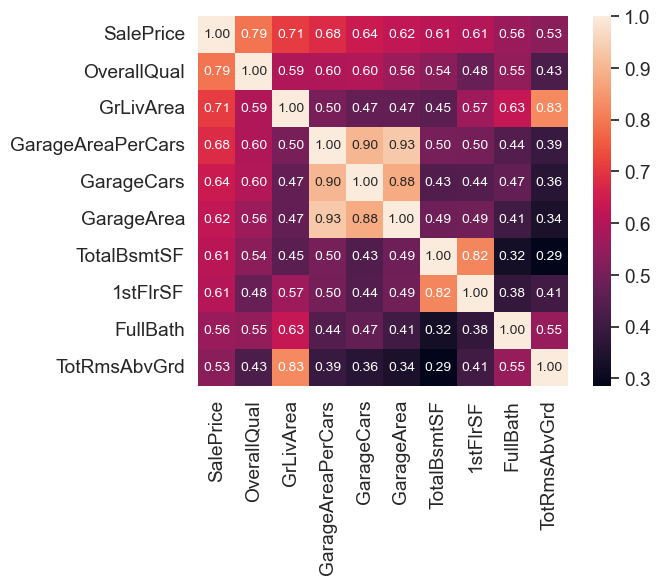

In [66]:
k = 10
corrmat = train.corr()
cols = corrmat.nlargest(k, "SalePrice")["SalePrice"].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

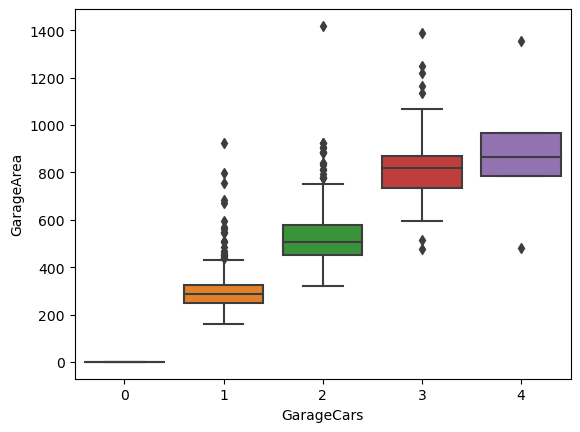

In [63]:
garage_data = pd.concat([train["GarageCars"], train["GarageArea"]], axis=1)
f, axis = plt.subplots()
fig = sns.boxplot(x="GarageCars", y="GarageArea", data=garage_data)

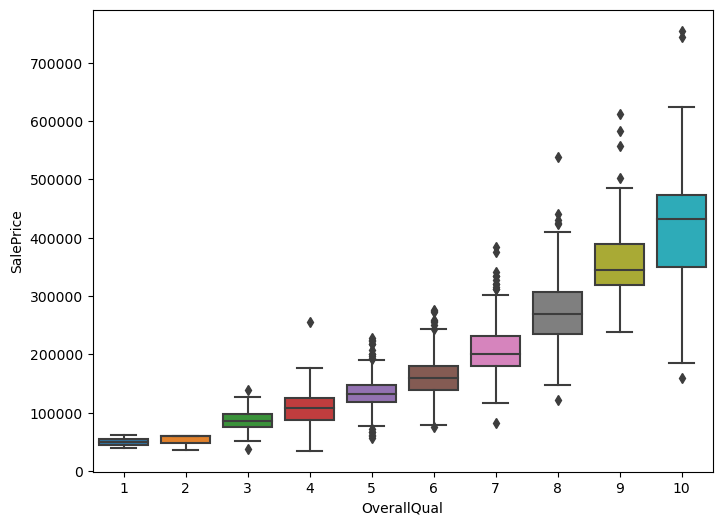

In [58]:
col = 'OverallQual'
data = pd.concat([train['SalePrice'], train[col]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=col, y="SalePrice", data=data)


c:\Users\D568\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


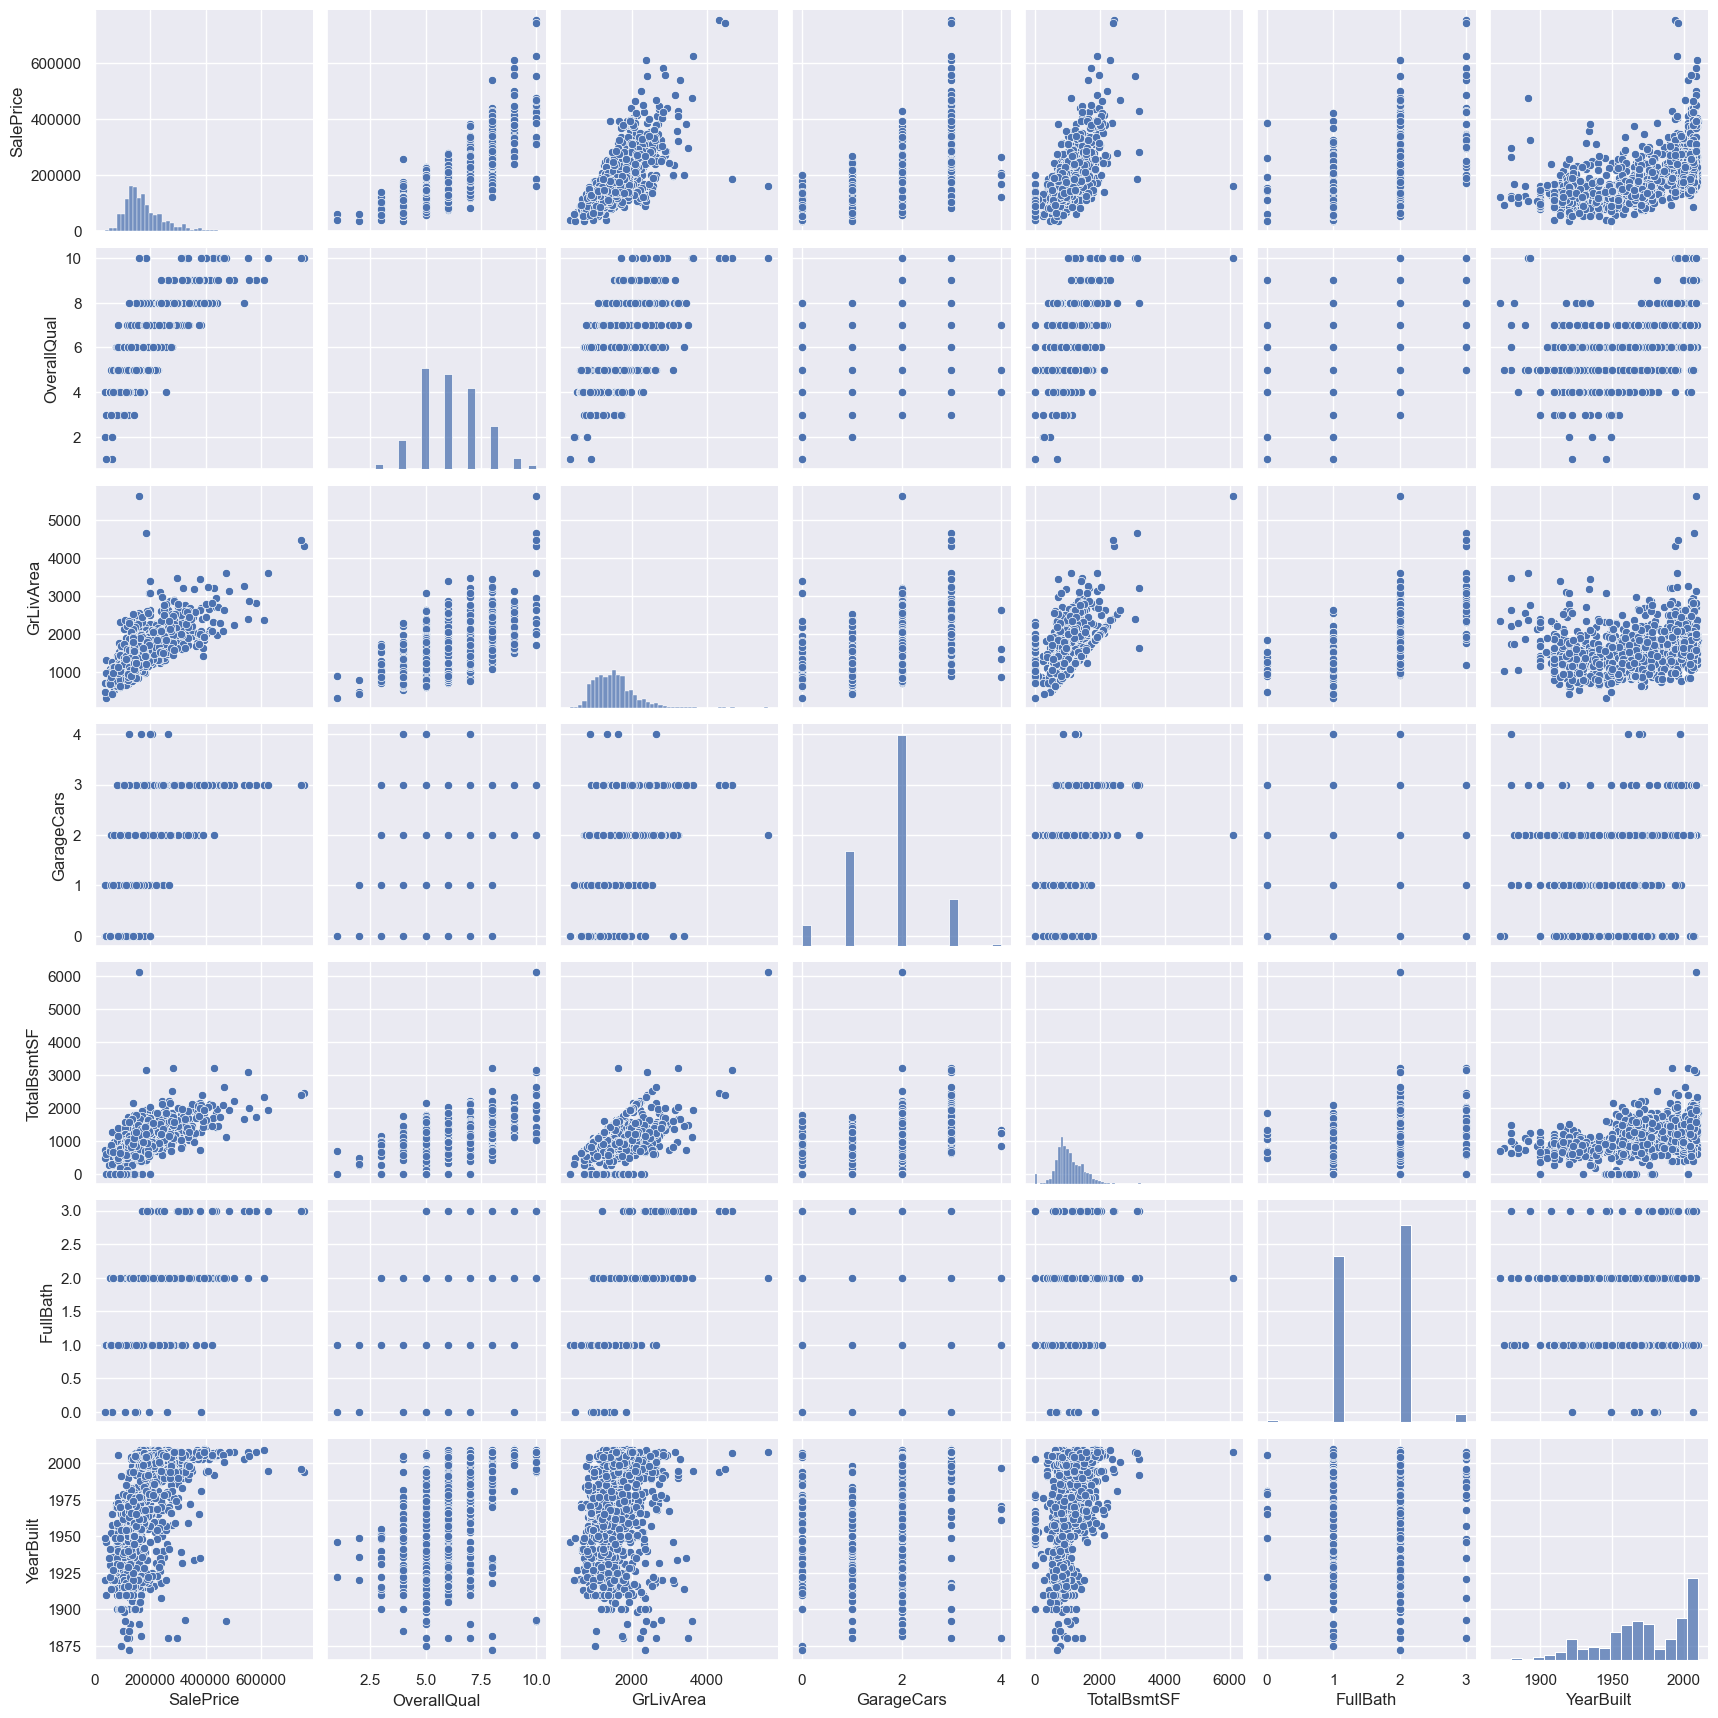

In [67]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size=2.5)
plt.show()